In [1]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import torch.optim as optim


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import joblib
import os

In [2]:
pd.read_csv("test.csv")

,Unnamed: 0,Filename,Label,ClassName
0,2438,AnnualCrop/AnnualCrop_1275.jpg,0,AnnualCrop
1,1018,Residential/Residential_504.jpg,7,Residential
2,3,Pasture/Pasture_787.jpg,5,Pasture
3,1011,Residential/Residential_1575.jpg,7,Residential
4,47,Pasture/Pasture_473.jpg,5,Pasture
...,...,...,...,...
2695,586,HerbaceousVegetation/HerbaceousVegetation_516.jpg,2,HerbaceousVegetation
2696,588,HerbaceousVegetation/HerbaceousVegetation_855.jpg,2,HerbaceousVegetation
2697,1985,SeaLake/SeaLake_2696.jpg,9,SeaLake
2698,1356,River/River_472.jpg,8,River


Custom Dataset

In [3]:
class EurosatData(Dataset):
    def __init__(self,csv_file, root_dir=None, transform = None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

        self.label_map = {label: idx for idx, label in enumerate(self.annotations['Label'].unique())}


    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        img_path = self.annotations['Filename'].iloc[idx]
        image = Image.open(img_path).convert('RGB')
        label_str = self.annotations['Label'].iloc[idx]

        if self.transform:
            image = self.transform(image)

        return image, label_str

Image trasnformation

In [4]:
train_transform = transforms.Compose([
    transforms.Resize(232), transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])
val_transform = transforms.Compose([
    transforms.Resize(232), transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

Dataset and DataLoader

In [5]:
# File Paths

train_csv = 'train.csv'
test_csv = 'test.csv'
val_csv = 'validation.csv'

train_dataset = EurosatData(train_csv, transform=train_transform)
test_dataset = EurosatData(test_csv, transform=val_transform)
val_dataset = EurosatData(val_csv, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle= True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle =False)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)


In [6]:
label_name = {
    "AnnualCrop": 0,
    "Forest": 1,
    "HerbaceousVegetation": 2,
    "Highway": 3,
    "Industrial": 4,
    "Pasture": 5,
    "PermanentCrop": 6,
    "Residential": 7,
    "River": 8,
    "SeaLake": 9
}

label_name_dict = {idx:label_value for label_value,idx in label_name.items()}

label_name_dict

{0: 'AnnualCrop',
 1: 'Forest',
 2: 'HerbaceousVegetation',
 3: 'Highway',
 4: 'Industrial',
 5: 'Pasture',
 6: 'PermanentCrop',
 7: 'Residential',
 8: 'River',
 9: 'SeaLake'}

torch.Size([128, 3, 224, 224])
torch.Size([128])


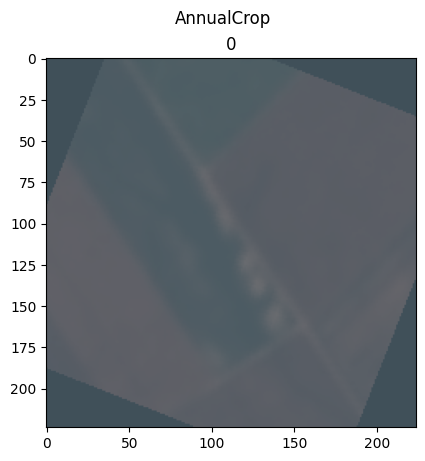

In [7]:
# Testing whether everything is fine or not
for images,label in train_loader:
    print(images.shape)
    print(label.shape)

    images = images * torch.tensor([0.0915,0.0652,0.0553]).view(3,1,1)
    images = images + torch.tensor([0.3445,0.3803,0.4077]).view(3,1,1)
    images = images.numpy()
    label = label.numpy()
    while True:
        plt.imshow(np.transpose(images[0], [1,2,0]))
        plt.suptitle(label_name_dict[label[0]])
        plt.title(label[0])

        # print(image_path[0])

        break
    break

Using ResNet for the image classification

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet34(pretrained= True)

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(train_dataset.label_map))

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

Training and Evaluating the model

In [9]:
def model_train(model, optimizer, loss_criterion, num_epochs=None):
    
    
    for epoch in range(num_epochs):
        total = 0.0
        total_correct = 0.0
        train_loss = 0.0

        val_total = 0.0
        val_correct = 0.0
        val_loss = 0.0
        model.train().to("cuda")
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            output = model(images)
            loss = loss_criterion(output, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.shape[0]
            total += labels.shape[0]
            pred = torch.argmax(output,dim=1)
            total_correct += (pred == labels).sum().item()
            # print(total_correct.item())
            # print(total)
            # print(pred)
            # print(labels)
        print(f"Training Loss in epoch {epoch} is {train_loss/total}")
        print(f'Training Accuracy is {total_correct/total} \n ')

        
        model.eval().to("cuda")
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
        
                output = model(images)
                loss = loss_criterion(output, labels)



                pred = torch.argmax(output, dim=1)
                val_loss += loss.item() * images.shape[0]
                val_total += labels.shape[0]
                val_correct += (pred == labels).sum().item()
            
            print(f"validation Loss in epoch {epoch} is {val_loss/val_total}")
            print(f'validation Accuracy is {val_correct/val_total} \n ')


    return model
    
model_train(model, optimizer, criterion, num_epochs=5)


Training Loss in epoch 0 is 0.955888417460931
Training Accuracy is 0.7249735449735449 
 
validation Loss in epoch 0 is 0.37052725081090576
validation Accuracy is 0.9116666666666666 
 
Training Loss in epoch 1 is 0.21777016534691765
Training Accuracy is 0.9386243386243386 
 
validation Loss in epoch 1 is 0.18205400615930556
validation Accuracy is 0.9488888888888889 
 
Training Loss in epoch 2 is 0.14050783886480583
Training Accuracy is 0.9577777777777777 
 
validation Loss in epoch 2 is 0.13036789352143252
validation Accuracy is 0.9625925925925926 
 
Training Loss in epoch 3 is 0.1070421904357022
Training Accuracy is 0.9653968253968254 
 
validation Loss in epoch 3 is 0.10535278389299357
validation Accuracy is 0.9672222222222222 
 
Training Loss in epoch 4 is 0.09030052825571999
Training Accuracy is 0.9711640211640211 
 
validation Loss in epoch 4 is 0.0949645235168713
validation Accuracy is 0.970925925925926 
 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Saving this model as .pth

In [10]:
torch.save(model.state_dict(), 'model_eurosat.pth')

Test Time:

In [ ]:
# Now lets load the model

model = models.resnet34(pretrained = False)
model.fc = nn.Linear(model.fc.in_features,10)

model.load_state_dict(torch.load('model_eurosat.pth'))

model= model.to(device)

In [12]:
all_preds = []
all_labels = []
all_probs = []


counter = 0
with torch.no_grad():
    model.eval()
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        output = model(images)
        prob = torch.softmax(output, dim=1)
        pred = torch.argmax(prob, 1)

        all_preds.extend(pred.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [ ]:
for images, labels in test_loader:
    images = images * torch.tensor([0.5,0.5,0.5]).view(3,1,1)
    images = images + torch.tensor([0.5,0.5,0.5]).view(3,1,1)
    images = images.numpy()
    labels = labels.numpy()
    i = np.random.random_integers(0,10)
    plt.imshow(np.transpose(images[i], [1,2,0]))
    plt.title(label_name_dict[label[i]])
    break

Classification Report

In [14]:
label_name = {
    "AnnualCrop": 0,
    "Forest": 1,
    "HerbaceousVegetation": 2,
    "Highway": 3,
    "Industrial": 4,
    "Pasture": 5,
    "PermanentCrop": 6,
    "Residential": 7,
    "River": 8,
    "SeaLake": 9
}

label_name_dict = {idx:label_value for label_value,idx in label_name.items()} # IWth Label_index and Name
label_values = [value for value in label_name_dict.values()] # Only Name

label_name_dict

{0: 'AnnualCrop',
 1: 'Forest',
 2: 'HerbaceousVegetation',
 3: 'Highway',
 4: 'Industrial',
 5: 'Pasture',
 6: 'PermanentCrop',
 7: 'Residential',
 8: 'River',
 9: 'SeaLake'}

In [15]:
from sklearn.metrics import classification_report
print("Classification Report")
print(classification_report(all_labels, all_preds, target_names= label_values))

Classification Report
                      precision    recall  f1-score   support

          AnnualCrop       0.98      0.95      0.97       300
              Forest       0.99      0.99      0.99       300
HerbaceousVegetation       0.96      0.98      0.97       300
             Highway       0.95      0.98      0.96       250
          Industrial       0.95      1.00      0.97       250
             Pasture       0.96      0.96      0.96       200
       PermanentCrop       0.95      0.91      0.93       250
         Residential       1.00      0.99      0.99       300
               River       0.97      0.96      0.96       250
             SeaLake       1.00      0.99      0.99       300

            accuracy                           0.97      2700
           macro avg       0.97      0.97      0.97      2700
        weighted avg       0.97      0.97      0.97      2700



Confusion Matrix

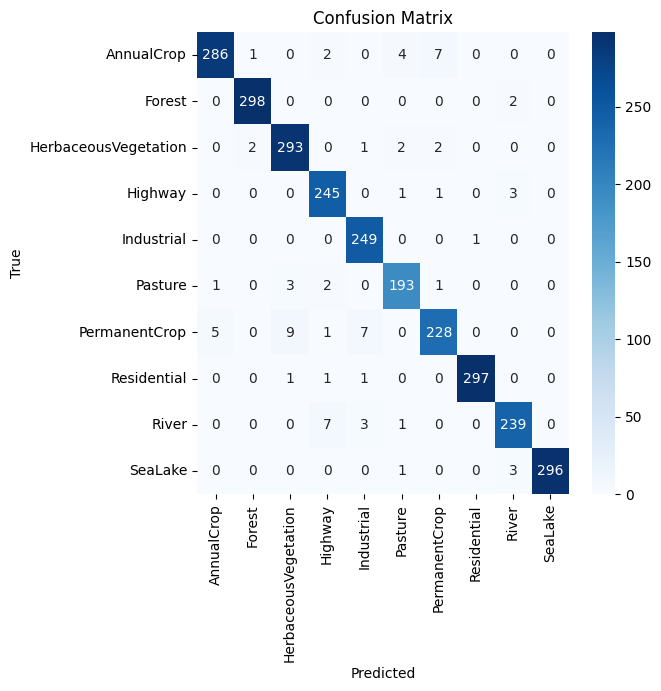

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cm = confusion_matrix(all_labels,all_preds)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels= label_values , yticklabels= label_values)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.title("Confusion Matrix")
plt.show()